In [1]:
import torch
from pyro.distributions import Empirical
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from numpyro.distributions import constraints
from numpyro.infer.util import log_likelihood
import jax
from jax import random
from jax import numpy as jnp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.stats import gaussian_kde

In [2]:
numpyro.set_platform("cpu")

In [3]:
numpyro.set_host_device_count(8)

In [4]:
# Step 1: Define the parameters for the two modes
mean1, std_dev1 = 30, 5
mean2, std_dev2 = 70, 7

# Step 2: Generate samples from each distribution
sample1 = np.random.normal(loc=mean1, scale=std_dev1, size=1000)
sample2 = np.random.normal(loc=mean2, scale=std_dev2, size=1000)

# Step 3: Combine the samples to create a bimodal distribution
bimodal_sample = np.concatenate((sample1, sample2))

In [5]:
bimodal_sample.mean(), bimodal_sample.std()

(50.14036410564683, 20.74642953146549)

In [6]:
import numpy as np
from scipy.stats import gaussian_kde
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt

# Step 1: Kernel Density Estimation using SciPy

# Generate synthetic data (replace with your data)
np.random.seed(0)
# data = np.random.normal(0, 1, 1000)
# data = np.random.beta(2, 5, 1000)
data = np.random.gamma(1, 1, 10000)
# data = bimodal_sample

# # SciPy KDE
# kde = gaussian_kde(data)

# # Define points where we want to estimate the PDF
# x_points = np.linspace(np.min(data), np.max(data), 1000)

# # Estimate the PDF using KDE
# pdf_estimated = kde.evaluate(x_points)

# # Step 2: Resampling using JAX

# # Create a cumulative distribution function (CDF) and normalize it
# cdf_estimated = np.cumsum(pdf_estimated) / np.sum(pdf_estimated)
# # cdf_estimated = cdf_estimated / cdf_estimated[-1] 

# # Inverse CDF function using linear interpolation
# def inv_cdf(p, x_points, cdf_estimated):
#     return jnp.interp(p, cdf_estimated, x_points)

# # Generate new samples using inverse transform sampling
# key = random.PRNGKey(0)
# new_samples = inv_cdf(random.uniform(key, (100000,)), jnp.array(x_points), jnp.array(cdf_estimated))

# # Plot the original data histogram and the resampled data histogram
# plt.figure(figsize=(12, 6))
# plt.hist(data, bins=30, alpha=0.5, label='Original Data', density=True)
# plt.hist(new_samples, bins=30, alpha=0.5, label='Resampled Data', density=True)
# plt.legend()
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.title('Original and Resampled Data')
# plt.show()


In [7]:
class Model():
    def __init__(self, parameters) -> None:
        self.params = parameters

In [8]:
Model(parameters={'a': 1, 'b': 2})
Model.parameters

AttributeError: type object 'Model' has no attribute 'parameters'

In [9]:
from numpyro.distributions import Distribution, constraints
import numpyro.distributions as dist
from numpyro.distributions.util import validate_sample
from jax import random
import jax.numpy as jnp
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class CustomKDEDistribution(Distribution):
    
    def __init__(self, data, validate_args=False):
        data = np.array(data)
        self.kde = gaussian_kde(data)  
        self.x_points = np.linspace(np.min(data) - 1, np.max(data) + 1, 100000)
        self.pdf_estimated = self.kde.evaluate(self.x_points)  
        self.cdf_estimated = jnp.cumsum(self.pdf_estimated) / jnp.sum(self.pdf_estimated) # Normalized
        self._batch_shape = ()
        self.support = constraints.real
        super(CustomKDEDistribution, self).__init__(batch_shape=self._batch_shape, validate_args=validate_args)

    def sample(self, key, sample_shape=()):
        # Generating samples using inverse transform sampling
        uniform_samples = random.uniform(key, sample_shape + self._batch_shape)
        samples = jnp.interp(uniform_samples, self.cdf_estimated, self.x_points)
        return samples

    def log_prob(self, value):
        # Validating the input sample
        validate_sample(value)
        
        # Getting the log probability using the KDE estimated PDF
        # Use linear interpolation to get the PDF values at the given points
        pdf_values_at_value = jnp.interp(value, self.x_points, self.pdf_estimated)
        log_prob = jnp.log(pdf_values_at_value)
        return log_prob

# Usage example:

# Generate synthetic data (replace with your data)
np.random.seed(0)
# data = np.random.normal(0, 1, 1000)
data = bimodal_sample

# Instantiate your custom distribution
cust_dist = CustomKDEDistribution(data)

# Get a JAX random key
key = random.PRNGKey(0)

# Generate samples
samples = cust_dist.sample(key, (10000,))

# Compute log probabilities
log_probs = cust_dist.log_prob(samples)

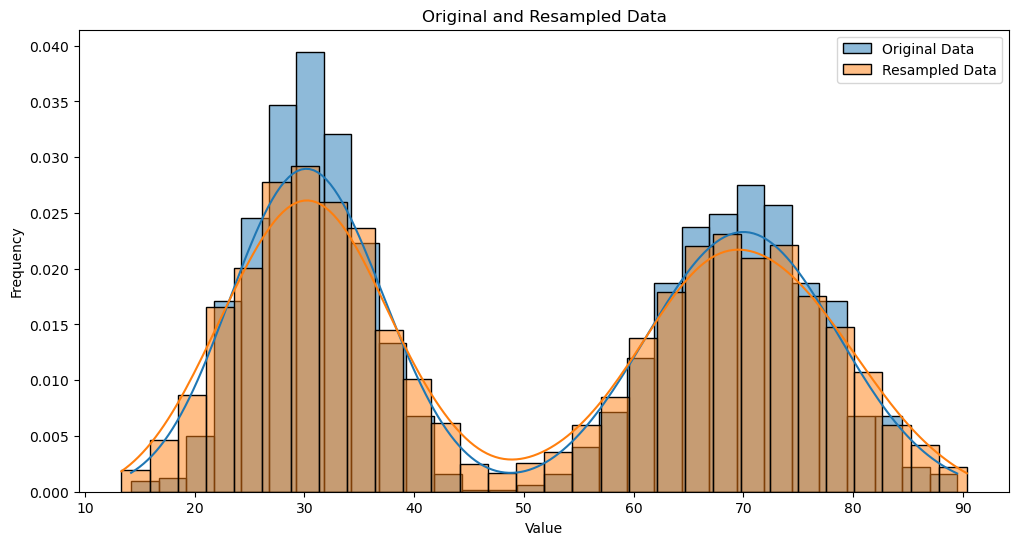

In [10]:
# Plot the original data histogram and the resampled data histogram
plt.figure(figsize=(12, 6))
sns.histplot(data, bins=30, alpha=0.5, label='Original Data', kde=True, stat='density')
sns.histplot(samples, bins=30, alpha=0.5, label='Resampled Data', kde=True, stat='density')
plt.legend()
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Original and Resampled Data')
plt.show()

<Axes: ylabel='Density'>

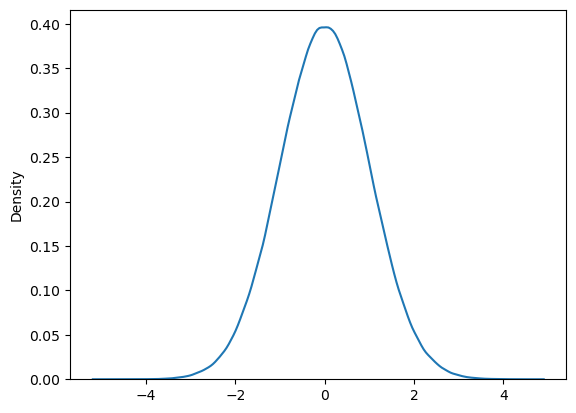

In [11]:
sns.kdeplot(np.random.normal(0, 1, 1000000), label='Original Data')

In [12]:
kde = gaussian_kde(dist.Normal(0, 1).sample(random.PRNGKey(0), (100000,)))

In [13]:
kde(0)

array([0.3984116])

In [14]:
np.log(kde(0))

array([-0.92026964])

In [15]:
np.log(kde(0))

array([-0.92026964])

In [16]:
dist.Normal(0, 1).log_prob(0)

Array(-0.9189385, dtype=float32, weak_type=True)

In [17]:
# Instantiate your custom distribution
cust_dist = CustomKDEDistribution(np.random.normal(0, 1, 40000))
cust_dist.log_prob(0)

Array(-0.93150675, dtype=float32)

In [12]:
x = jnp.array(np.random.normal(10, 8, 10000))

In [13]:
x.mean(), x.std()

(Array(9.974516, dtype=float32), Array(7.98151, dtype=float32))

<Axes: ylabel='Density'>

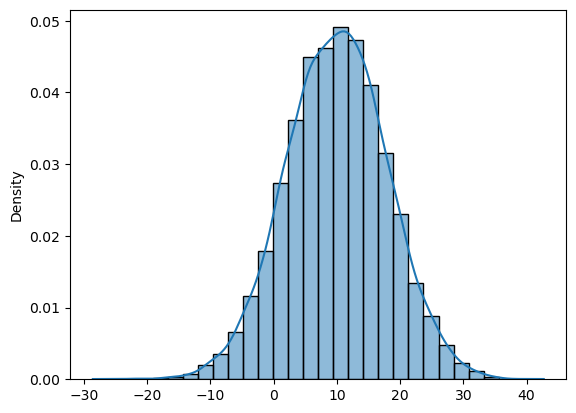

In [14]:
sns.histplot(x, stat='density', bins=30, kde=True)

In [16]:
def model(x):
    # Priors
    # # mu = numpyro.sample("mu", dist.Normal(0, 1))
    mu = numpyro.sample("mu", CustomKDEDistribution(x))
    sigma = numpyro.sample("sigma", dist.HalfNormal(20))

    # # Likelihood
    y = numpyro.sample("y", dist.Normal(mu, sigma), obs=x)
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS
kernel = NUTS(model, target_accept_prob=0.95)
mcmc = MCMC(kernel, num_warmup=10000, num_samples=10000, num_chains=4, chain_method='parallel', progress_bar=True)
mcmc.run(rng_key, x)
mcmc.print_summary()

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      9.98      0.08      9.98      9.85     10.11  28067.48      1.00
     sigma      7.98      0.06      7.98      7.89      8.08  28820.28      1.00

Number of divergences: 0


In [20]:
mcmc.get_samples()

{'mu': Array([ 0.3460541 ,  1.1097242 , -0.54372734, ..., -0.9595342 ,
        -0.4129722 ,  0.63071096], dtype=float32),
 'sigma': Array([4.805556  , 0.07639568, 4.6741214 , ..., 2.0048718 , 0.9105292 ,
        0.7050866 ], dtype=float32)}

In [17]:
dist.sample(key, (10,)).mean()

Array(39.038105, dtype=float32)

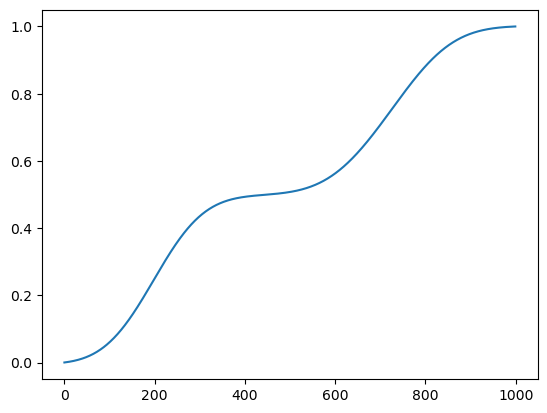

In [37]:
plt.plot(np.cumsum(pdf_estimated)/pdf_estimated.sum())

In [44]:
a = [1,1,3,1,1]
gaussian_kde(a)(np.arange(0,5))

array([0.14980991, 0.49337696, 0.18725895, 0.12730113, 0.0374628 ])

In [41]:
np.cumsum() / 5

array([0.2, 0.4, 0.6, 0.8, 1. ])

In [ ]:
np.cumsum([1,1,1,1,1]) * 

In [38]:
(x_points[1] - x_points[0])

0.07555229028376864

In [39]:
1/pdf_estimated.sum()

0.07609105323087935

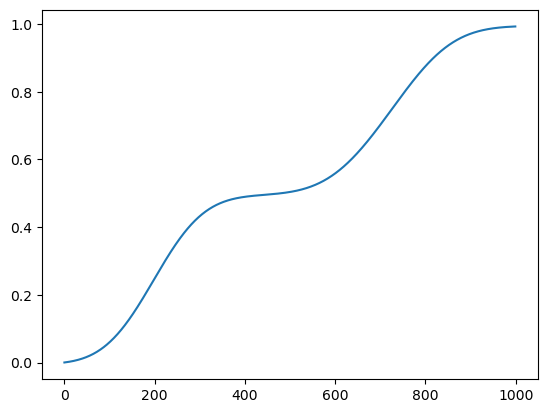

In [35]:
plt.plot(np.cumsum(pdf_estimated) * (x_points[1] - x_points[0]))

In [32]:
new_samples.mean(), new_samples.std()

(Array(50.04488, dtype=float32), Array(20.926544, dtype=float32))

In [1]:
import torch
from pyro.distributions import Empirical
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from numpyro.distributions import constraints
from numpyro.infer.util import log_likelihood
import jax
from jax import random
from jax import numpy as jnp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.stats import gaussian_kde

In [2]:
numpyro.set_platform("cpu")

In [3]:
numpyro.set_host_device_count(4)

In [4]:
# Set random seed
np.random.seed(123)

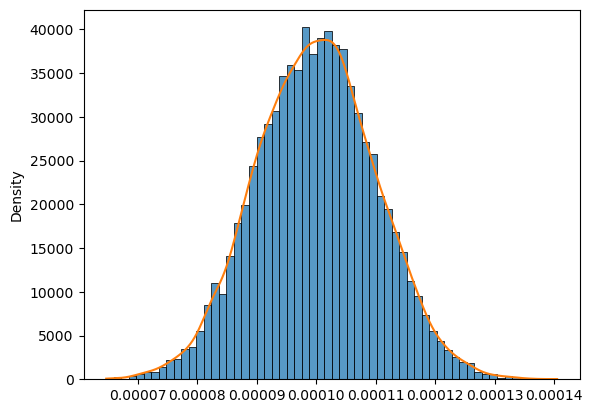

In [7]:
x = np.random.normal(10, 1, size=(10000,))
# x = np.random.gamma(1, 1, size=(100000,))

x = x / np.sum(x)

# Calculate kernel density estimate (KDE) of x
kde = gaussian_kde(x)

# Plot KDE of x
x_plot = np.linspace(np.min(x), np.max(x), 1000)

fig, ax = plt.subplots()
sns.histplot(x, stat="density", ax=ax);
ax.plot(x_plot, kde(x_plot), color="C1", label="KDE");

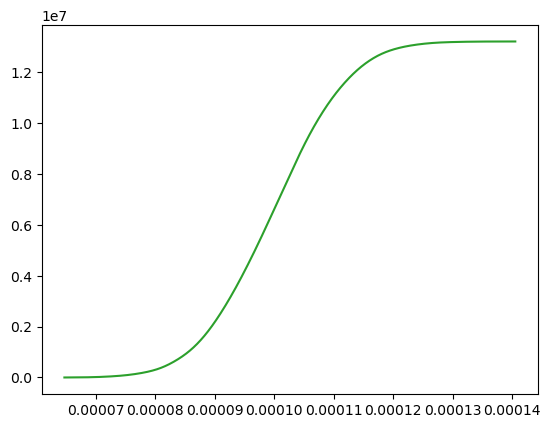

In [8]:
# convert kde to cdf
cdf = np.cumsum(kde(x_plot))
plt.plot(x_plot, cdf, color="C2", label="CDF")

In [55]:
uniform_samples = np.random.uniform(0, 1, size=(10000,))

In [56]:
jnp.searchsorted(cdf, uniform_samples)

Array([389, 388, 395, ..., 393, 397, 352], dtype=int32)

In [50]:
dist_array = jnp.array()

In [51]:
# dist_array = dist_array / jnp.sum(dist_array)

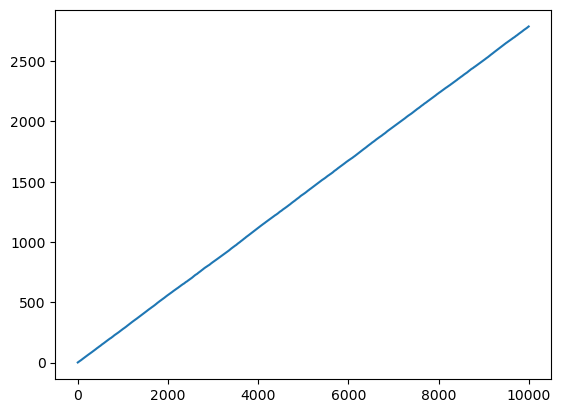

In [52]:
plt.plot(jnp.cumsum(dist_array))

In [26]:
a = np.aalinspace(min(x), max(x), 100)
a

array([ 6.1986218 ,  6.27811145,  6.3576011 ,  6.43709075,  6.51658039,
        6.59607004,  6.67555969,  6.75504934,  6.83453898,  6.91402863,
        6.99351828,  7.07300793,  7.15249757,  7.23198722,  7.31147687,
        7.39096652,  7.47045616,  7.54994581,  7.62943546,  7.70892511,
        7.78841475,  7.8679044 ,  7.94739405,  8.0268837 ,  8.10637335,
        8.18586299,  8.26535264,  8.34484229,  8.42433194,  8.50382158,
        8.58331123,  8.66280088,  8.74229053,  8.82178017,  8.90126982,
        8.98075947,  9.06024912,  9.13973876,  9.21922841,  9.29871806,
        9.37820771,  9.45769735,  9.537187  ,  9.61667665,  9.6961663 ,
        9.77565594,  9.85514559,  9.93463524, 10.01412489, 10.09361454,
       10.17310418, 10.25259383, 10.33208348, 10.41157313, 10.49106277,
       10.57055242, 10.65004207, 10.72953172, 10.80902136, 10.88851101,
       10.96800066, 11.04749031, 11.12697995, 11.2064696 , 11.28595925,
       11.3654489 , 11.44493854, 11.52442819, 11.60391784, 11.68

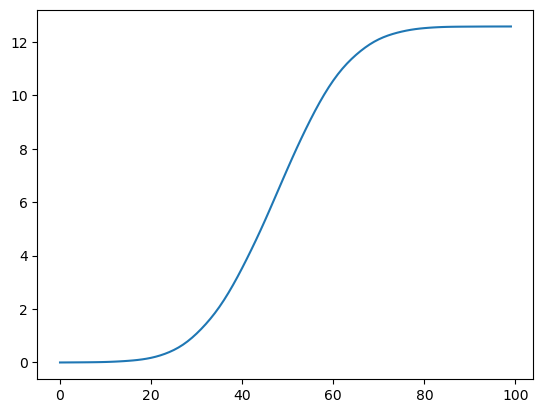

In [36]:
plt.plot(jnp.cumsum(kde(a)))

<Axes: ylabel='Count'>

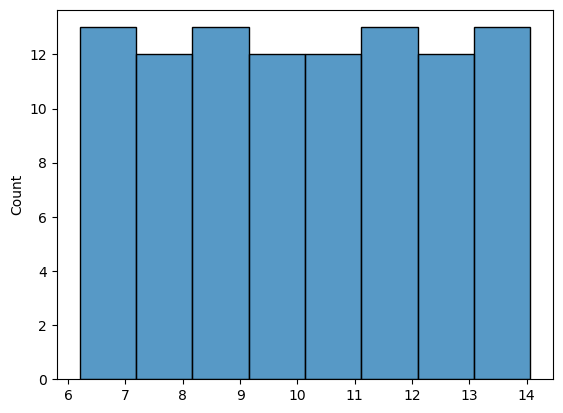

In [32]:
sns.histplot(a)

In [49]:
import jax.numpy as jnp
from jax import random

# Create a series of points where to evaluate the KDE
x_ls = np.linspace(min(x), max(x), 1000)

# Get the distribution array by evaluating the KDE at the points in x
distribution_array = kde.evaluate(x)

# # Define the distribution array (use the array you provided)
# distribution_array = jnp.array(kde(x)[:100])

# Normalize the distribution array
distribution_array = distribution_array / jnp.sum(distribution_array)

# Function to sample from the distribution
def sample_from_distribution(rng_key, distribution, num_samples):
    # Calculate the CDF
    cdf = jnp.cumsum(distribution)
    
    # Sample uniformly random values
    uniform_samples = random.uniform(rng_key, shape=(num_samples,))
    
    # Inverse transform sampling
    samples = jnp.searchsorted(cdf, uniform_samples)
    
    return samples

# Generate a large number of samples (1 million)
rng_key = random.PRNGKey(0)
num_samples = 1000000
samples = sample_from_distribution(rng_key, distribution_array, num_samples)

# Calculate the mean and standard deviation of the samples
mean_estimate = jnp.mean(samples)
std_estimate = jnp.std(samples)

print("Mean estimate:", mean_estimate)
print("Standard deviation estimate:", std_estimate)


Mean estimate: 4981.3047
Standard deviation estimate: 2886.5964


In [1]:
samples

NameError: name 'samples' is not defined

In [36]:
np.reshape(kdea

In [24]:
InterpolatedUnivariateSpline(np.ones_like(x), x, k=1)

ValueError: x must be strictly increasing

In [17]:
data = np.random.normal(9.9, 1.1, size=(1000,))

In [18]:
# # Convert x to a PyTorch tensor
# x = torch.tensor(x)
# print(x.mean(), x.std())

In [19]:
# y = Empirical(x, torch.ones(100000,)).sample((10000000,))
# print(y.mean(), y.std())
# # print(Empirical(x, torch.ones(100000,)).log_prob((0,)))

# Implementation in Numpyro

In [20]:
class Custom(dist.Distribution):
    support = constraints.positive
    def __init__(self, x):
        self.x = x
        super().__init__(batch_shape=x.shape, event_shape=())

    def sample(self, key, sample_shape=()):
        # return self.x
        raise NotImplementedError

    def log_prob(self, value):
        return jnp.log(1 / (1 + jnp.exp(-value)))

In [21]:
def model(x):
    # Priors
    # mu = numpyro.sample("mu", dist.Normal(0, 1))
    mu = numpyro.sample("mu", Custom(x))
    sigma = numpyro.sample("sigma", dist.Exponential(1))

    # # Likelihood
    numpyro.sample("y", dist.Normal(mu, sigma), obs=data)

In [22]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4, chain_method='parallel', progress_bar=True)
mcmc.run(rng_key, x)
# mcmc.print_summary()

ValueError: Incompatible shapes for broadcasting: shapes=[(10000,), (1000,)]

In [14]:
mcmc_samples = mcmc.get_samples()

In [13]:
mcmc_samples['mu'].mean(), mcmc_samples['mu'].std()

(Array(9.960702, dtype=float32), Array(1.2693117, dtype=float32))

In [3]:
import jax.numpy as jnp
from numpyro.distributions import Distribution
from numpyro.distributions.util import is_prng_key, validate_sample
from jax import random

class EmpiricalDistribution(Distribution):
    def __init__(self, samples):
        self.samples = samples
        batch_shape = jnp.shape(samples)[:-1]
        super(EmpiricalDistribution, self).__init__(batch_shape=batch_shape, event_shape=())

    def sample(self, key, sample_shape=()):
        if not is_prng_key(key):
            raise ValueError("Key must be a valid JAX PRNG key")
        indices = random.randint(key, sample_shape + self.batch_shape, 0, len(self.samples))
        return self.samples[indices]

    def log_prob(self, value):
        # Ensure value has the correct shape
        if jnp.shape(value) != self.batch_shape + self.event_shape:
            raise ValueError(f"Value has incorrect shape; expected {self.batch_shape + self.event_shape}, got {jnp.shape(value)}")
        
        # Here we compute the log probability as the log of the empirical density
        # which is not normalized properly. This is just for illustration purposes.
        kernel_width = 0.1  # You may need to tune this value
        diff = value[..., jnp.newaxis] - self.samples[jnp.newaxis, ...]
        log_probs = -0.5 * (diff / kernel_width) ** 2
        return jnp.log(jnp.mean(jnp.exp(log_probs), axis=-1))

In [4]:
key = random.PRNGKey(0)
samples = jnp.array([1.0, 1.1, 1.3, 2.0, 2.1, 3.0])  # Replace with your array of samples
empirical_dist = EmpiricalDistribution(samples)

# Generate new samples
new_samples = empirical_dist.sample(key, (1000,))

# Compute log probabilities of the new samples
log_probs = empirical_dist.log_prob(new_samples)


ValueError: Value has incorrect shape; expected (), got (1000,)

In [12]:
random.randint(key, (10,), 1, 5)

Array([3, 2, 4, 3, 4, 2, 3, 4, 1, 3], dtype=int32)